# TP 2

#### Grupo 4: Aschieri Juan Pablo, Civini Diego Emanuel, Rivero Joaquin, Rovira Rossel Francisco

In [131]:
from math import e, log
import time
from heapq import heappush, heappop
from scipy.stats import poisson
import matplotlib.pyplot as plt
import itertools
import simpy
import numpy as np
import random
from statistics import mean
import seaborn as sns
import pandas as pd

## Generador de numeros aleatorio del TP1

In [132]:
class Xorshift_generator:
    def __init__(self, seed):
        self.x = seed
        self.y = 463820370
        self.z = 138409373
        self.w = 12872349

    def rand(self):
        tmp = ( self.x ^ (self.x << 13) ) 
        self.x = self.y
        self.y = self.z
        self.z = self.w
        self.w = (self.w^(self.w>>17) ) ^ (tmp^(tmp>>5))
        return self.w & 0xffffffff
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

In [133]:
class Uniform_generator:
    def __init__(self, seed, scale= 1, displacement= 0):
        self.xorshift_genertor = Xorshift_generator(seed)
        self.scale = scale
        self.displacement = displacement

    def rand(self):
        n = self.xorshift_genertor.rand() / ((2**32)-1)
        return n * self.scale + self.displacement
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

In [134]:
class Exp_generator:
    def __init__(self, seed, parameter=1):
        self.parameter = parameter
        self.Uniform_generator = Uniform_generator(seed)

    def rand(self):
        r = self.Uniform_generator.rand()
        if self.parameter >=1:
            return log(r) / (-1 * self.parameter)
        else: 
            return -log(1 - r) / self.parameter

    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

In [135]:
seed = int(time.time())

exp_generator = Exp_generator(seed, 1/6)

#b = exp_generator.rand()
#b = exp_generator.rand()
a = []

for i in range(100):
    n = exp_generator.rand()
    a.append(n)
    if n < 0:
        print(n)

print(a)
print(sum(a)/len(a))

[2.536448032731035, 2.073924732120855, 4.3574088857470175, 9.402098204322067, 7.93897994311854, 9.968880388115117, 1.3057216021337132, 10.189961684418616, 4.251356257811314, 3.1723901776452657, 1.0953451852639957, 0.9005579448180527, 1.2137201039015557, 1.2395990439964872, 7.936884525858917, 0.20181715264520128, 16.320952802632576, 0.29296467661726383, 17.119694898012167, 2.9177741984626437, 1.3936052209162915, 1.706035780096985, 5.126841899639719, 4.306411070448323, 28.298859388513872, 16.319747133395758, 4.882813083649666, 10.112962511018738, 17.33309716696757, 4.718454240483208, 1.824409200405616, 2.0836331646911863, 12.10057645517509, 4.859421304728221, 3.1272097395104983, 5.4656572112575175, 6.926417861898156, 0.18026725319570033, 3.71857276443274, 8.252510773255604, 4.89536611147792, 8.129296491803398, 3.166305376474509, 0.9557259278406907, 0.684336430549509, 11.58759834966603, 7.0243634947043265, 11.12673634652887, 1.8829958027611666, 2.757103579522867, 0.9132937276969163, 0.181

## Ejercicio 1

### Programacion tradicional

Definimos un generador de una distribucion de poisson porque lo utilizaremos mas adelante.

In [136]:
def factorial(n):
    resultado = 1
    for i in range(1, n + 1):
        resultado *= i
    return resultado

def poisson_probability(parameter, i, previous_probability):
    if previous_probability == 0:
        return poisson.pmf(i, parameter)
    return (parameter/i)*previous_probability

class Poisson_generator:
    def __init__(self, seed, parameter):
        self.parameter = parameter
        self.Uniform_generator = Uniform_generator(seed)

    def rand(self):
        r = self.Uniform_generator.rand()

        accumulated_probability = poisson_probability(self.parameter, 0, 0)
        previous_probability = accumulated_probability
        i = 0

        while(accumulated_probability < r):
            i += 1
            previous_probability = poisson_probability(self.parameter, i, previous_probability)
            accumulated_probability += previous_probability

        return i
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

Asumimos que el satélite da siempre la misma vuelta al mundo que tarda lo mismo, y que se puede pensar al tiempo en que tarda el satelite en llegar a una posicion a la que puede sacar una foto de la request como una uniforme entre 0 y el tiempo en que tarda en dar la vuelta al mundo, ya que los puntos sobre el globo se distribuyen uniformemente.

Para simular el problema lo que hacemos es definir un delta de tiempo (time step), que sera de cada que intervalo discreto avanzaremos el tiempo de la simulacion. Por cada iteracion generamos un valor de una distribucion de poisson que representa la cantidad de arribos de solicitudes que llegaron en el ultimo intervalo de tiempo. Por cada solicitud de tiempo que halla llegado luego generamos un valor de tiempo con una distribucion uniforme entre 0 y el satelite_perior (tiempo en dar la vuelta al mundo del satelite), que representa el tiempo que tardara el satelite en estar en posicion para poder sacar la foto. Por cada iteracion avanzamos el tiempo de todas las request en la cola, y agregamos las nuevas, ademas de ir anotando datos como cuantas veces hubo cada longitud de cola en todas las iteraciones, y cuanto fue el tiempo para servir a la primera request para cada longitud de cola.

In [137]:
def simulate_satelite_request_queue_length(time_step, iterations, request_per_unit_time, satelite_period):
    generator_amount_of_request = Poisson_generator(int(time.time()) * 8647359734, request_per_unit_time*time_step)
    generator_time_to_serve = Uniform_generator(int(time.time()) * 345678976, satelite_period)
    simulated_queue = []
    observed_queue_length = {}
    time_to_serve_first_for_queue_length = {}

    for _ in range(iterations):
        advance_time(simulated_queue, time_step)
        get_acumulated_requests(generator_amount_of_request, simulated_queue, generator_time_to_serve)    
        observed_queue_length[len(simulated_queue)] = observed_queue_length.get(len(simulated_queue), 0) + 1
        if len(simulated_queue) != 0:
            time_to_serve_first_for_queue_length.setdefault(len(simulated_queue), []).append(simulated_queue[0])
            
    return get_frequencies(observed_queue_length, iterations), get_mean_times(time_to_serve_first_for_queue_length)

In [138]:
def advance_time(simulated_queue, time_step):
    for i in range(len(simulated_queue)):
        simulated_queue[i] -= time_step

    while (len(simulated_queue) != 0 and simulated_queue[0] <= 0):
        item = heappop(simulated_queue)
        #print(f'Se elimino una request de tiempo: {item}')

def get_acumulated_requests(generator_amount_of_request, simulated_queue, generator_time_to_serve):
    amount_of_requests = generator_amount_of_request.rand()
    for request in range(amount_of_requests):
        #por ahora asumimos que el time to serve es uniforme, porque se hacen requests uniformemente alrededor del mundo
        heappush(simulated_queue, generator_time_to_serve.rand())

def get_frequencies(observed_queue_length, iterations):
    #print(f'Entro a get_frequencies con dicc = {observed_queue_length}')
    observed_frequencies = []
    #print(f'El maximo es: {max(observed_queue_length.keys())}')
    for j in range(max(observed_queue_length.keys()) + 1):
        times_observed = observed_queue_length.get(j, 0)
        #print(f'Para {j} se observo {times_observed}')
        observed_frequencies.append(times_observed/iterations)
    return observed_frequencies

def get_mean_times(time_to_serve_for_queue_length):
    mean_times = {}

    for key in time_to_serve_for_queue_length:
        sum_of_times = 0
        for j in time_to_serve_for_queue_length[key]:
            sum_of_times += j
        mean_times[key] = sum_of_times/len(time_to_serve_for_queue_length[key])
    
    return mean_times

Simulamos un ejemplo donde tomamos que el satelite tarde 48 horas en dar la vuelta al mundo, y que llegan 10 requests por dia en promedio. Usamos un intervalo de media hora y realizamos 50 000 horas de simulacion

In [139]:
frequencies, times_to_serve_first = simulate_satelite_request_queue_length(0.5, 100000, 5/12, 48)

Podemos ver que como en general se acumulan las request hasta llegar al rededor de 10 y luego tiende a disminuir la cantidad que hay

In [140]:
def satelite_frequencies_graph(frequencies):
    x_axis = list(range(len(frequencies)))
    y_axis = frequencies
    plt.plot(x_axis, y_axis)
    plt.show()

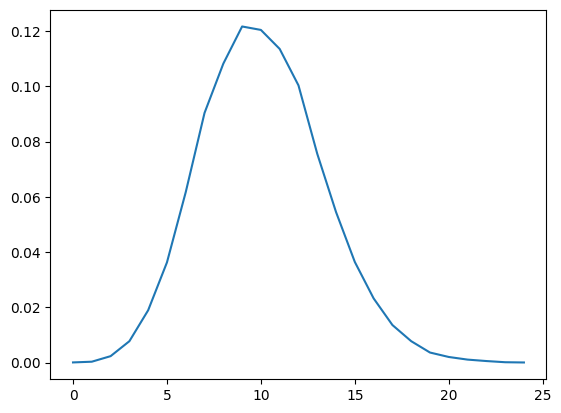

In [141]:
satelite_frequencies_graph(frequencies)

El paper llegaba a la conclusion de que cuantas mas solicitudes hayan en la cola, el tiempo que se tarda en servir estas request es menor. Para verificar esto miramos el siguiente grafico que muestra el tiempo promedio que tarda el satelite en servir al request mas cercano

In [142]:
def satelite_times_to_serve_first(times_to_serve_first):
    plt.bar(times_to_serve_first.keys(), times_to_serve_first.values())
    plt.xlabel("Queue length")
    plt.ylabel("Avarege time to serve first request")
    plt.show()

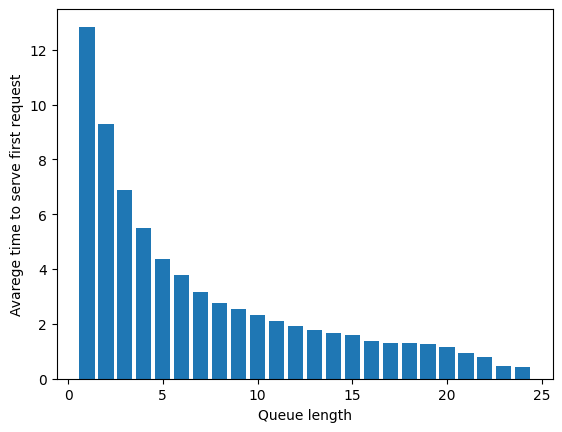

In [143]:
satelite_times_to_serve_first(times_to_serve_first)

Vemos que en este caso asi sucede, cuantas mas solicitudes hay en la cola menor es el tiempo para tomar la foto. Esto tiene sentido ya que cuantas mas request hayan en espera mas chances habra de que haya alguna mas cercana.
Si bien el grafico solo muestra la primera requet, como esto se modela como un proceso de poisson, por propiedad de perdidad de memoria se puede ver que se cumplira para el tiempo entre todos los arribos. 

### Simpy 

Para realizar la simulacion utilizando simpy vamos a definir dos procesos. Por un lado el satelite_request_generator que va a generar request, cada un lapso de tiempo aleatorio segun una distribucion exponencial de parametro request_per_unit_time. Cada request tiene un tiempo uniforme entre 0 y satellite_period y es pusheada al heap.

In [144]:
def satelite_process_queue(env, simulated_queue, time_step, observed_queue_length, time_to_serve_first_for_queue_length):
    while True:
        yield env.timeout(time_step)
        advance_time(simulated_queue, time_step) 
        observed_queue_length[len(simulated_queue)] = observed_queue_length.get(len(simulated_queue), 0) + 1
        if len(simulated_queue) != 0:
            time_to_serve_first_for_queue_length.setdefault(len(simulated_queue), []).append(simulated_queue[0])

In [145]:
def satellite_request_gen(env, simulated_queue, satellite_period, request_per_unit_time):
    exp_generator = Exp_generator(int(time.time()) * 324324234, request_per_unit_time)
    uni_generator = Uniform_generator(int(time.time()) * 54735235, satellite_period)
    while True:
        time_for_next_req = exp_generator.rand()
        time_for_image = uni_generator.rand()
        yield env.timeout(time_for_next_req)
        heappush(simulated_queue, time_for_image)
        

In [146]:
env = simpy.Environment()

simulated_queue = []
observed_queue_length = {}
time_to_serve_first_for_queue_length = {}
satellite_period = 48
request_per_unit_time = 5/12
time_step = 0.5
iterations = 100000
env.process(satellite_request_gen(env, simulated_queue, satellite_period, request_per_unit_time))
env.process(satelite_process_queue(env, simulated_queue, time_step, observed_queue_length, time_to_serve_first_for_queue_length))
env.run(time_step*iterations)

In [147]:
frequencies, times_to_serve_first = get_frequencies(observed_queue_length, iterations), get_mean_times(time_to_serve_first_for_queue_length)

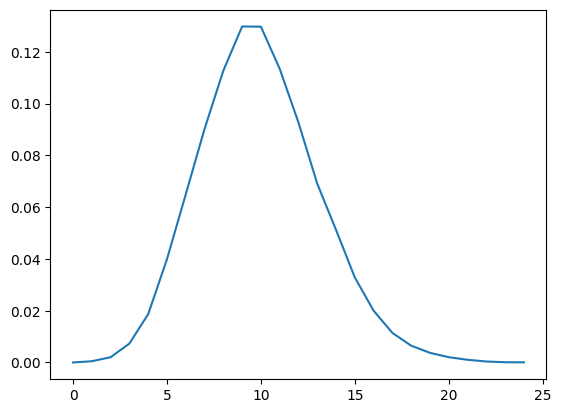

In [148]:
satelite_frequencies_graph(frequencies)

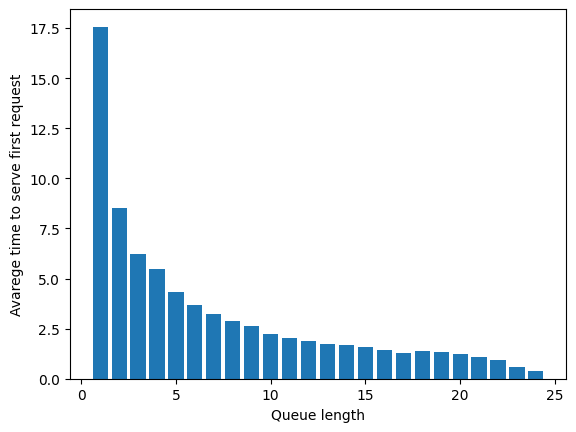

In [149]:
satelite_times_to_serve_first(times_to_serve_first)

## Ejercicio 2

In [150]:
SIM_TIME = 7*24*60 # Minutos 

- Factor de ocupación del sistema. (listo)
- Cantidad media de solicitudes en el buffer (listo)
- Cantidad media de solicitudes en el sistema (listo)
- Tiempo medio que las solicitudes están en el buffer (listo)
- Tiempo medio de solicitudes en el sistema (listo)
- Determinar el tamaña del buffer para que la probabilidad de que haya lugar para recibir solicitudes sea
como mucho 3%.
- Evaluar la posibilidad de reemplazar las dos máquinas por una sola que procesa todos las solicitudes en
un tiempo fijo de 5 segundos. Si el costo de tener solicitudes en el buffer es 0,2 USD/minuto y el costo
de modificar la máquina es 2000 USD, Cuánto tiempo tomará amortizar el inversión?

De esta manera cada maquina es un proceso y desp hay otro proceso que se encarga de llenar las lista con requests para que cada maquina vaya desencolando 
y procesando requests

In [151]:
class Machine:
    
    def __init__(self,id):
        self.working_time = 0
        self.requests_taken = 0
        self.id = id
        self.req_time_stats = []
        self.procesing_requests = False
    
    def process_request(self, request):
        self.requests_taken += 1
        self.working_time += request

    def add_req_time_stat(self, time_tup):
        # The tuple has the following format: (req_buffer_time, req_system_time, req_finish_time)
        self.req_time_stats.append(time_tup)

    def is_processing_requests(self):
        return self.procesing_requests

class RequestQueueStats:
    def __init__(self, queue_length):
        self.queue_length = queue_length
        self.rejected_requests = 0
        self.total_requests = 0
        self.amount_of_requests_in_queue = []
        self.amount_of_requests_in_system = []

    def inc_rejected_requests(self):
        self.rejected_requests +=1
        self.total_requests +=1
    
    def inc_accepted_requests(self):
        self.total_requests +=1

    def rejected_ratio(self):
        return self.rejected_requests / self.total_requests
    
    def add_amount_of_requests_in_queue(self, amount_of_requests):
        self.amount_of_requests_in_queue.append(amount_of_requests)

    def add_amount_of_requests_in_system(self, amount_of_requests):
        self.amount_of_requests_in_system.append(amount_of_requests)

    def mean_amount_of_requests_in_queue(self):
        aux = mean(self.amount_of_requests_in_queue)
        print(f"cantidad media de elementos en el buffer: {aux}")
        return aux

    def mean_amount_of_requests_in_system(self):
        aux = mean(self.amount_of_requests_in_system)
        print(f"cantidad media de elementos en el buffer: {mean(self.amount_of_requests_in_system)}")
        return aux
        

In [152]:
"""
Con esta implementacion, las maquinas chequean que haya requests en la cola cada 1 seg. Osea, que si la cola estaa vacia, la maquina cada 1 seg va a 
chequear si llego un nuevo mensaje. Ver con los chicos si estan de acuerdo con esto (o tamb preguntar al de la practica). Porque otro caso que CREO que se puede
hacer es que apenas llegue un request, la maquina ya sepa y lo empieze a procesar all instante.
Tambien ver que onda el arrribo de mensajes, estan llegando cada mucho tiempo y los procesa re rapido entonces la cola siempre esta vacia
"""
def request_generator(env, requests_buffer, seed, requests_stats, request_queue_size):
    """Las solicitudes llegan siguiendo un proceso Poisson con una frecuencia media de 10
    por minuto. Por ende el tiempo entre 2 solicitudes consecutivas seguira una distribucion
    Exponencial de paremtro 10."""
    exponential_gen = Exp_generator(seed, 10) 
    
    #print("Requests start to arrive")
    for i in itertools.count():
        time_for_next_request = exponential_gen.rand()
        #time_for_next_request = np.random.exponential(1/10) # El parametro en esta lib tiene que ser b=1/lambda

        #print(f"The next request will arrive in {time_for_next_request}, we are at {env.now}")
        yield env.timeout(time_for_next_request)
        #with requests_center.request() as req:
            #yield req
        if len(requests_buffer.items) == request_queue_size:
            requests_stats.inc_rejected_requests() 
            #print(f"The buffer is full and cannot accept more requests. This requests has been dropped at time {env.now}")
        else:
            #print(f"A request arrived and was buffered at time {env.now}")
            requests_stats.inc_accepted_requests()
            yield requests_buffer.put(env.now)
    #print("Requests will stop to arrive")


In [153]:
def processing_machine(env, requests_center, requests_buffer, seed, machine, new_machine):
    
    '''Se procesan 6 requests por minuto'''
    exponential_gen = Exp_generator(seed, 6)
    
    while True:
        
        time_to_process = 0.01
        request_processed = False
        with requests_center.request() as req:
            yield req
            
            if len(requests_buffer.items) != 0:
                machine.procesing_requests = True
                arrival_time = yield requests_buffer.get()
                #print(arrival_time)
                buffer_time = env.now - arrival_time
                #print(f"La cantidad de requests en el buffer es {len(requests_buffer.items)}")
                if not new_machine:
                    time_to_process = exponential_gen.rand()
                    #time_to_process = np.random.exponential(1/6)
                else: 
                    time_to_process = 5/60 # si 1 unidad de tiempo es 1 minuto, entonces 5 segundos son 5/60 minutos

                #time_to_process = np.random.exponential(10)
                machine.process_request(time_to_process)
                #print(f"Machine {machine.id} will finish at {time_to_process + env.now}")
                request_processed = True
          
        # If there are no requests to process in the buffer, the timeout is of 0 seconds.
        yield env.timeout(time_to_process)
        if request_processed:
            machine.procesing_requests = False
            system_time = env.now - arrival_time
            finish_time = arrival_time + system_time
            time_tup = (buffer_time, system_time, finish_time)
            machine.add_req_time_stat(time_tup)
            #print(f"Machine {machine.id} has finished processing the request at {env.now}")

In [154]:
def buffer_stats(env, buffer, requests_queue_stats, machines):
    while True:
        requests_in_buffer = len(buffer.items)
        requests_queue_stats.add_amount_of_requests_in_queue(requests_in_buffer)
        requests_in_system = requests_in_buffer
        for machine in machines:
            if machine.is_processing_requests():
                requests_in_system += 1

        requests_queue_stats.add_amount_of_requests_in_system(requests_in_system)
        yield env.timeout(1/60)

podemos usar nuestro generador, ronda cantidad de llegadas 11/12 en el primer minuto (empiricamente), varias veces se pasa y muy pocas veces de menos, el otro es mas uniforme, puede dar 8 o 13.  
voy a dejar el otro por ahora

In [155]:
def processing_center_simulation(request_queue_size, new_system):
    env = simpy.Environment()
    requests_center = simpy.Resource(env, 1)
    requests_buffer = simpy.Store(env, request_queue_size)
    requests_queue_stats = RequestQueueStats(request_queue_size)
    env.process(request_generator(env, requests_buffer, int(time.time())*4564564522, requests_queue_stats, request_queue_size))

    machines = []
    if not new_system:
        machine_1 = Machine(1)
        machine_2 = Machine(2)
        machines.append(machine_1)
        machines.append(machine_2)
        env.process(buffer_stats(env, requests_buffer, requests_queue_stats, machines))
        env.process(processing_machine(env, requests_center, requests_buffer, int(time.time())* 1324568457, machine_1, new_system))
        env.process(processing_machine(env, requests_center, requests_buffer, int(time.time()) * 124214123, machine_2, new_system))
    else:
        machine_0 = Machine(0)
        machines.append(machine_0)
        env.process(buffer_stats(env, requests_buffer, requests_queue_stats, machines))
        env.process(processing_machine(env, requests_center, requests_buffer, int(time.time())* 1324568457, machine_0, new_system))


    env.run(until=SIM_TIME)

    return machines, requests_queue_stats


In [156]:
machines, request_queue_stats = processing_center_simulation(15, False)

Ocupation factor con una maquina

In [157]:
m1_ocupation_factor = machines[0].working_time/SIM_TIME
m2_ocupation_factor = machines[1].working_time/SIM_TIME
print(f"machine 1 ocupation_factor: {m1_ocupation_factor}")
print(f"machine 2 ocupation_factor: {m2_ocupation_factor}")


machine 1 ocupation_factor: 0.8279591140944647
machine 2 ocupation_factor: 0.8248812646147413


Ocupation factor con dos maquinas

In [158]:
ocupation_factor = (machines[0].working_time + machines[1].working_time)/(SIM_TIME*2)
print(f"ocupation_factor: {ocupation_factor}")

ocupation_factor: 0.826420189354603


Cantidad media de elementos en el buffer: a cada segundo mido la cantidad de elementos en el buffer, luego divido la suma por la cantidad total de mediciones

In [159]:
mean_amount_of_requests_in_queue = request_queue_stats.mean_amount_of_requests_in_queue()

cantidad media de elementos en el buffer: 3.0437019780059886


Calculamos la cantidad media de solicitudes en el sistema

In [160]:
request_queue_stats.mean_amount_of_requests_in_system()

cantidad media de elementos en el buffer: 4.69657788264239


4.69657788264239

avg time in buffer

In [161]:
def avg_time(requests, index):
    time_in_buffer = 0
    for time_tup in requests:
        time_in_buffer += time_tup[index]
    return time_in_buffer/len(requests)

In [162]:
machine1_buffer_time = avg_time(machines[0].req_time_stats, 0)
machine2_buffer_time = avg_time(machines[1].req_time_stats, 0)

avg_buff_time = (machine1_buffer_time + machine2_buffer_time)/2

print(f"avg time in buffer: {avg_buff_time} minutes")
print(f"avg time in buffer: {avg_buff_time*60} seconds")

avg time in buffer: 0.3067915452274139 minutes
avg time in buffer: 18.407492713644835 seconds


avg time in system

In [163]:
machine1_sys_time = avg_time(machines[0].req_time_stats, 1)
machine2_sys_time = avg_time(machines[1].req_time_stats, 1)

avg_sys_time = (machine1_sys_time + machine2_sys_time)/2

print(f"avg time in system: {avg_sys_time} minutes")
print(f"avg time in system: {avg_sys_time*60} seconds")

avg time in system: 0.47338904285391903 minutes
avg time in system: 28.403342571235143 seconds


Determinar el tamaño del buffer para que la probabilidad de que NO haya lugar para recibir solicitudes sea
como mucho 3%.

Para verificar que se rechazan como mucho 3% de las solucitudes lo que hacemos es calcular el rejected ratio, es decir cuantas solicitudes no entraron en el buffer dividio la cantidad de solicitudes totales. Si bien este resultado depende de la muestra, consideramos que es confiable debido a la alta cantidad de muestras (que se toman cada 1 segundo), dado a que simulamos una semana de tiempo

Usando lo ya simulado con una cola de tama;o 15 vemos que el rejected_ratio cumple con ser menor a 0.03

In [164]:
request_queue_stats.rejected_ratio()

0.008211271656237295

Para obtener cual es el menor valor de longitud de la request_queue como ya sabemos que con 15 cumple, simulamos reduciendo la longitud de la request_queue hasta que no se cumpla la condicion.

In [165]:
queue_size = 15
rejected_ratio = request_queue_stats.rejected_ratio()
while rejected_ratio < 0.03:
    queue_size -= 1
    _, aux_request_queue_stats = processing_center_simulation(queue_size, False)
    rejected_ratio = aux_request_queue_stats.rejected_ratio()
    print(f"El rejected ratio con una longitud de cola {queue_size}  = {rejected_ratio}")
print(f'El mayor tamaño de cola que no cumple la condicion es {queue_size}, por lo que el menor tamaño de buffer con el que conseguimos un rejected ratio menor a 0.03 es {queue_size + 1}')

El rejected ratio con una longitud de cola 14  = 0.010174114742511274
El rejected ratio con una longitud de cola 13  = 0.011492078034595735
El rejected ratio con una longitud de cola 12  = 0.01700626180300169
El rejected ratio con una longitud de cola 11  = 0.016821892264508385
El rejected ratio con una longitud de cola 10  = 0.023393951373789287
El rejected ratio con una longitud de cola 9  = 0.026862147979883146
El rejected ratio con una longitud de cola 8  = 0.03411209392725398
El mayor tamaño de cola que no cumple la condicion es 8, por lo que el menor tamaño de buffer con el que conseguimos un rejected ratio menor a 0.03 es 9


Evaluar la posibilidad de reemplazar las dos máquinas por una sola que procesa todos las solicitudes en
un tiempo fijo de 5 segundos. Si el costo de tener solicitudes en el buffer es 0,2 USD/minuto y el costo
de modificar la máquina es 2000 USD, Cuánto tiempo tomará amortizar el inversión?

Para ver en cuanto tiempo se amortiza la nueva maquina, consideramos que se debe pagar 0,2 por cada tarea por cada minuto que una tarea este en el sistema. Por que en promedio, cada sistema genera un gasto por miuto de cantidad_media_en_el_buffer * 0,2.Si queremos obtener en que momento se amortiza la inversion inicial de la nueva maquina tenemos que plantear la siguiente ecuacion.  
(cantidad_media_en_el_buffer_del_viejo_sistema *0,2)t = (cantidad_media_en_el_buffer_del_nuevo_sistema*0,2)t + 2000  
despejando t obtenemos  
t = 2000 / (cantidad_media_en_el_buffer_del_viejo_sistema *0,2 - cantidad_media_en_el_buffer_del_nuevo_sistema*0,2) 

In [166]:
mean_amount_of_requests_in_queue_old_system = mean_amount_of_requests_in_queue

Simulamos con una cola de igual longitud bajo el nuevo sistema

In [167]:
_, request_queue_stats = processing_center_simulation(15, True)
mean_amount_of_requests_in_queue_new_system = request_queue_stats.mean_amount_of_requests_in_queue()

cantidad media de elementos en el buffer: 2.06378296332182


Calculamos el tiempo hasta amortizar la inversion inicial

In [168]:
time_to_break_even = 2000 / (mean_amount_of_requests_in_queue_old_system * 0.2 - mean_amount_of_requests_in_queue_new_system * 0.2)
print(f"Se tardarian {time_to_break_even} minutos")
time_to_break_even = time_to_break_even/60
print(f"Se tardarian {time_to_break_even} horas")
time_to_break_even = time_to_break_even/24
print(f"Se tardarian {time_to_break_even} dias")

Se tardarian 10204.92494803056 minutos
Se tardarian 170.082082467176 horas
Se tardarian 7.086753436132334 dias


## EJERCICIO 3

In [169]:
SIM_TIME_3 = 30 * 24

### Primera version

In [170]:
class Truck:

    def __init__(self, env, id, arrival_time):
        self.env = env
        self.id = id
        self.arrival_time = arrival_time
        self.download_shipment_time = None
        self.finish_time = None


    def download_shipment(self, distribution_center, exp_generator):
        
        with distribution_center.request() as req:
            yield req
            self.download_shipment_time = env.now
            time_to_download = exp_generator.rand()
            
            yield env.timeout(time_to_download)
        self.finish_time = env.now
            

def truck_generator(env, distribution_center, seed, trucks, type, trucks_per_unit_time):
    arraival_time_generator = Exp_generator(seed, trucks_per_unit_time)
    if type == 'barcode':
        download_time_generator = Exp_generator(int(time.time()) * 345783456, 2)
    else:
        download_time_generator = Exp_generator(int(time.time()) * 345783456, 12/5)

    for i in itertools.count():
        time_for_next_truck = arraival_time_generator.rand()
        yield env.timeout(time_for_next_truck)
        
        truck = Truck(env, i, env.now)
        env.process(truck.download_shipment(distribution_center, download_time_generator))
        trucks.append(truck)



Escenario en el que se usa codigo de barras para descargar y hay 4 darsenas

In [171]:
env = simpy.Environment()
distribution_center = simpy.Resource(env, 4)

trucks = []
env.process(truck_generator(env, distribution_center, int(time.time()) * 235462324, trucks, 'barcode', 5))
env.run(SIM_TIME_3)

Estadísticas:
-  Simular ambos escenarios utilizando Simpy o programación tradicional.
-  Cantidad media de camiones en el sistema (listo)
-  Cantidad media de camiones en cola (listo)
-  Tiempo medio de camiones en el sistema (listo)
-  Tiempo medio de camiones en cola (listo)
-  Qué recomendación se puede hacer sobre el cierre de la dársena propuesto

In [172]:
# We cheack for every second how many trucks were in the system, buffer, their times, etc.
system_quantity = []
buffer_quantity = []
trucks_time_stats = []
curr_time = 0
while curr_time < SIM_TIME_3:
    trucks_in_system = 0
    trucks_in_buffer = 0
    for truck in trucks:
        #if curr_time < 20:
        #    print(f"arrival_time: {truck.arrival_time}      truck.download_shipment_time: {truck.download_shipment_time}      truck.finish_time: {truck.finish_time}")
        if not all([truck.download_shipment_time,truck.finish_time]):
            # If the truck never got out of the buffer or system before the simulation ended, their times cannot be taken into account
            continue

        if truck.arrival_time < curr_time < truck.finish_time:
            trucks_in_system += 1

        if truck.arrival_time < curr_time < truck.download_shipment_time:
            trucks_in_buffer += 1
    system_quantity.append(trucks_in_system)
    buffer_quantity.append(trucks_in_buffer)
    curr_time += 0.2

trucks_system_time = [truck.finish_time - truck.arrival_time for truck in trucks if all([truck.download_shipment_time,truck.finish_time])]
trucks_buffer_time = [truck.download_shipment_time - truck.arrival_time for truck in trucks if all([truck.download_shipment_time,truck.finish_time])]

print("mean system quantity",mean(system_quantity))
print("mean buffer quantity",mean(buffer_quantity))
print("mean trucks system time ",mean(trucks_system_time))
print("mean trucks buffer time",mean(trucks_buffer_time))
print("buffer quantity",buffer_quantity)

mean system quantity 2.986111111111111
mean buffer quantity 0.4452777777777778
mean trucks system time  0.6046775739579828
mean trucks buffer time 0.09106893321425408
buffer quantity [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 2, 2, 3, 4, 3, 3, 2, 0, 0, 0, 0, 0, 2, 4, 4, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 3, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 3, 6, 6, 4, 4, 4, 3, 2, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 2, 3, 2, 3, 2, 1, 1, 2, 0, 0, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Escenario en el que se usa RFID para descargar y hay 3 darsenas

In [173]:
def run_simulation(seed):

    random.seed(seed)

    env = simpy.Environment()
    distribution_center = simpy.Resource(env, 4)

    trucks = []
    env.process(truck_generator(env, distribution_center, int(time.time()), trucks, 'rfid',5))

    env.run(2000)

    print("trucks", trucks)
    buffer_quantity = []
    for second in range(2000):
        trucks_in_buffer = 0
        for truck in trucks:
            if not all([truck.download_shipment_time,truck.finish_time]):
                # If the truck neever got out of the buffer or system before the simulation ended, their times cannot be taken into account.
                continue
            if truck.arrival_time < second < truck.download_shipment_time:
                trucks_in_buffer += 1
        buffer_quantity.append(trucks_in_buffer)
    print(buffer_quantity)
    return mean(buffer_quantity)

#def get_trucks_in_buffer_mean(trucks):
#    buffer_quantity = []
#    for second in range(2000):
#        trucks_in_buffer = 0
#        for truck in trucks:
#            print(f'{truck.arrival_time}    -    {truck.download_shipment_time}')
#            if not all([truck.download_shipment_time,truck.finish_time]):
#                # If the truck neever got out of the buffer or system before the simulation ended, their times cannot be taken into account.
#                continue
#            if truck.arrival_time < second < truck.download_shipment_time:
#                trucks_in_buffer += 1
#        buffer_quantity.append(trucks_in_buffer)
#
#    print(buffer_quantity)
#    return mean(buffer_quantity)

# NOSE PORQ ESTA FUNCION NO FUNCA, EL M QUE ME DEVUELVE run_simulation es siempre 0
def rfid_analysis():
    uniform_gen = Uniform_generator(int(time.time()))
    mean_vector = []
    for _ in range(2):
        seed = uniform_gen.rand()
        m = run_simulation(seed)
        #print(len(trucks))
        #m = get_trucks_in_buffer_mean(trucks)
        print(m)
        mean_vector.append(m)
    
    plt.hist(mean_vector)
    plt.show()
    
    return mean_vector

trucks [<__main__.Truck object at 0x7f0d3d1dce50>, <__main__.Truck object at 0x7f0d2def83a0>, <__main__.Truck object at 0x7f0d2defa7d0>, <__main__.Truck object at 0x7f0d2defb370>, <__main__.Truck object at 0x7f0d2defb820>, <__main__.Truck object at 0x7f0d2def89a0>, <__main__.Truck object at 0x7f0d2def8a90>, <__main__.Truck object at 0x7f0d2def8ac0>, <__main__.Truck object at 0x7f0d2def8af0>, <__main__.Truck object at 0x7f0d2def8ca0>, <__main__.Truck object at 0x7f0d2defa8f0>, <__main__.Truck object at 0x7f0d2def9ae0>, <__main__.Truck object at 0x7f0d2def9c00>, <__main__.Truck object at 0x7f0d2def9c90>, <__main__.Truck object at 0x7f0d2def8760>, <__main__.Truck object at 0x7f0d2defb8b0>, <__main__.Truck object at 0x7f0d2def8820>, <__main__.Truck object at 0x7f0d2def9600>, <__main__.Truck object at 0x7f0d2def96c0>, <__main__.Truck object at 0x7f0d2def9750>, <__main__.Truck object at 0x7f0d2def9810>, <__main__.Truck object at 0x7f0d2def99f0>, <__main__.Truck object at 0x7f0d2def88b0>, <__

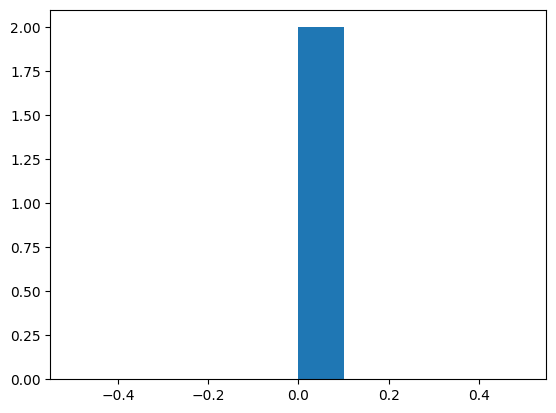

In [174]:
l = rfid_analysis()

In [175]:
random.seed(22)

env = simpy.Environment()
distribution_center = simpy.Resource(env, 3)

trucks = []
env.process(truck_generator(env, distribution_center, int(time.time()), trucks, 'rfid', 5))

env.run(SIM_TIME_3)


buffer_quantity = []
for second in range(SIM_TIME_3):
    trucks_in_buffer = 0
    for truck in trucks:
        if not all([truck.download_shipment_time,truck.finish_time]):
            # If the truck never got out of the buffer or system before the simulation ended, their times cannot be taken into account.
            continue
        if truck.arrival_time < second < truck.download_shipment_time:
            trucks_in_buffer += 1
    buffer_quantity.append(trucks_in_buffer)

mean(buffer_quantity)

0.9152777777777777

In [176]:
gen=Exp_generator(int(time.time()) * 1234124124124, 5)


In [177]:
l = gen.get_n_rand(10000)
gen_py = np.random.exponential(1/5, 1000)
mean(l)
#mean(gen_py)


0.2019746845046779

In [178]:
uni_gen = Uniform_generator(int(time.time()) * 1234124124124)

0.20183873005069777


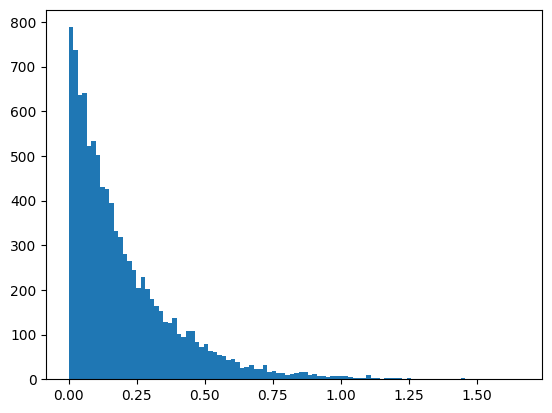

In [179]:
l = gen.get_n_rand(10000)
print(mean(l))
plt.hist(l, bins = 100)
plt.show()

## EJERCICIO 4

Una entidad financiera está analizando cambiar uno de sus cajeros automáticos por uno con la funcionalidad de
reciclador de billetes (si un cliente realiza un depósito de efectivo, ese efectivo estará disponible para que lo
pueda retirar otro cliente).  
El cajero automático actual, que se quiere reemplazar, es de tipo estándar. No recicla los billetes, sino que
posee dos compartimentos, uno con dinero para entregar y otro donde guarda el dinero que se deposita.
Esto presenta los siguientes problemas:  

+ Si no tiene más efectivo para entregar en el compartimento de retiro de dinero, no entrega efectivo
aunque tenga en el compartimento de depósitos.
+ Si el compartimento que recibe los depósitos se completa, no puede recibir más.

La entidad conoce que con el cajero actual el 20% de los clientes se retiraba sin poder extraer dinero, y sólo
acepta cambiarlo si este porcentaje disminuye.  
Por simplicidad suponer que el cajero sólo expende billetes de $100, tiene una capacidad máxima de 2000
billetes, y comienza el día con su carga completa.  
Si un cliente quiere extraer dinero y el cajero no cuenta con la suma suficiente, se va del mismo sin retirar nada.  
Algo similar ocurre cuando un cliente desea depositar efectivo y la capacidad máxima de billetes en el cajero fue
alcanzada, retirándose sin poder depositar.  
En el relevamiento que realizó la entidad diferenció a sus clientes en dos grupos:  
+ Grupo 1: Sólo retiran efectivo, y corresponden al 75% de los clientes que arriban.  
El tiempo que utilizan el cajero se puede modelar con una distribución exponencial de media 90
segundos.  
Cada cliente de este grupo, extrae una cantidad de billetes que sigue una distribución uniforme
[3,50].  
+ Grupo 2: Sólo realizan depósitos, son el 25% de los clientes totales.  
Utilizando el cajero un tiempo que siguen una distribución exponencial de media 5 minutos.  
Cada cliente de este grupo, deposita una cantidad de billetes que se puede modelar utilizando
una distribución uniforme [10,110].

La frecuencia de arribos de clientes es de 1 cliente cada 10 minutos con distribución exponencial.  
Se pide:  
1. Simular 1000 días completos de 24 hrs.
1. Para un día en particular graficar la cantidad de billetes en el cajero luego de cada transacción.
1. Calcular el tiempo medio que los clientes demoraron en el sistema (espera + utilización del cajero)
1. ¿Recomienda a la entidad que implemente el cambio de cajero?

El ejercicio se puede resolver utilizando Simpy o programación tradicional (a elección del grupo)

In [180]:
SIM_TIME_4 = 1000 * 24 * 60 # 1000 dia en minutos
TIMES_SIM = 1000 # Cantidad de dias a simular

In [181]:
class Atm:
    def __init__(self):
        self.operaciones_exitosas = 0
        self.operaciones_fallidas = 0
        self.billetes = 2000
        self.billetes_depositados = 0
        self.max_billetes = 2000

    def extraction(self, cantidad):
        if cantidad > self.billetes:
            self.operaciones_fallidas +=1
            return 0
        self.billetes -= cantidad
        self.operaciones_exitosas +=1
        return cantidad
    
    def deposit(self, cantidad):
        if cantidad + self.billetes_depositados > self.max_billetes:
            self.operaciones_fallidas +=1
            return 0
        self.billetes_depositados += cantidad
        self.operaciones_exitosas +=1
        return cantidad
    
    def print_stats(self):
        print("operaciones exitosas           ",self.operaciones_exitosas)
        print("operaciones fallidas           ",self.operaciones_fallidas)
        print("billetes                       ",self.billetes)
        print("billetes depositados           ",self.billetes_depositados)
        print("billetes + billetes depositados",self.billetes + self.billetes_depositados)
    
    

In [182]:
class Cajero_Reciclador:
    def __init__(self):
        self.operaciones_exitosas = 0
        self.operaciones_fallidas = 0
        self.billetes = 2000
        self.max_billetes = 2000

    def deposit(self, cantidad):
        if cantidad + self.billetes > self.max_billetes:
            self.operaciones_fallidas +=1
            return 0
        self.billetes += cantidad
        self.operaciones_exitosas +=1
        return cantidad
    
    def extraction(self, cantidad):
        if cantidad > self.billetes:
            self.operaciones_fallidas +=1
            return 0
        self.billetes -= cantidad
        self.operaciones_exitosas +=1
        return cantidad

In [183]:
class Client:
    def __init__(self, atm):
        self.atm = atm

    def deposit(self, env, time_to_deposit, amount):
            yield env.timeout(time_to_deposit)
            self.atm.deposit(amount)

    def extraction(self, env, time_to_extract, amount):
            yield env.timeout(time_to_extract)
            self.atm.extraction(amount)


In [184]:
def arrival_of_clients(env, atm, resource, day):
    time_gen = Exp_generator(int(time.time()) * day * 12345678, 1/10) # Generador de tiempo entre llegada de clientes
    transaction_gen = Uniform_generator(int(time.time()) *day * 24579411) # Generador de probabilidad para extraccion o deposito
    extraction_time_gen = Exp_generator(int(time.time()) *day * 44859889, 2/3) # Generador de tiempo para extracciones
    deposit_time_gen = Exp_generator(int(time.time() *day * 45621154), 1/5) # Generador de tiempo para depositos
    extraction_amount_gen = Uniform_generator(int(time.time()) *day * 72895245, 3, 50) # Generador de cantidad de billetes a extraer
    deposit_amount_gen = Uniform_generator(int(time.time()) *day * 5788932, 10, 110) # Generador de cantidad de billetes a depositar
    
    while True:
        time_for_next_client = time_gen.rand()
        #print(f"next client in {time_for_next_client}")
        yield env.timeout(time_for_next_client)
        client = Client(atm)

        with resource.request() as req:
            yield req
            if transaction_gen.rand() < 0.75:
                time_to_extract = extraction_time_gen.rand()
                amount = int(extraction_amount_gen.rand())
                #print("extraction",amount)
                #print(f"amount extracted {amount} [time: {time_to_extract}]")
                env.process(client.extraction(env,time_to_extract, amount))
            else:
                time_to_deposit = deposit_time_gen.rand()
                amount = int(deposit_amount_gen.rand())
                #print("deposit",amount)
                #print(f"amount deposited {amount} [time: {time_to_deposit}]")
                env.process(client.deposit(env,time_to_deposit, amount))

In [185]:
atms = []
def day_of_work(list,n):
    for i in range(n):
        env = simpy.Environment()
        resource = simpy.Resource(env, 1)
        atm = Atm()
        env.process(arrival_of_clients(env, atm, resource, i))
        env.run(until=SIM_TIME)
        list.append(atm)
        print()

In [186]:
day_of_work(atms, 5)


In [187]:
for i in range(len(atms)):
    print(f"ATM {i}")
    atms[i].print_stats()
    print("\n")

ATM 0
operaciones exitosas            56
operaciones fallidas            938
billetes                        6
billetes depositados            1963
billetes + billetes depositados 1969


ATM 1
operaciones exitosas            56
operaciones fallidas            917
billetes                        16
billetes depositados            1957
billetes + billetes depositados 1973


ATM 2
operaciones exitosas            56
operaciones fallidas            965
billetes                        4
billetes depositados            1932
billetes + billetes depositados 1936


ATM 3
operaciones exitosas            56
operaciones fallidas            969
billetes                        9
billetes depositados            1950
billetes + billetes depositados 1959


ATM 4
operaciones exitosas            56
operaciones fallidas            1001
billetes                        16
billetes depositados            1937
billetes + billetes depositados 1953




xq da siempre 56 operaciones exitosas ???